In [2]:
%matplotlib inline

import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

from scipy import stats

FIGURE_PATH = '../figures/'
DATA_PATHZ = '../data/'

THRESH = 0.00046  # bonferroni correction

In [9]:
def ll_values(values):
    signs = np.sign(values)
    vals = np.log10(np.abs(values) + 1)
    return vals * signs

def cliffsd(u, n1, n2):
    d = (2*u) / (n1 * n2) - 1
    return abs(d)

def cd_name(cd):
    if cd < 0.1:
        return 'n'
    elif 0.1 <= cd < 0.33:
        return 's'
    elif 0.33 <= cd < 0.474:
        return 'm'
    elif 0.474 <= cd:
        return 'l'

def print_boxes_size(df, save=False):
    names = {'lines_added': '#lines added',
             'lines_deleted': '#lines deleted',
             'num_files': '#files modified',
             'num_hunks': '#hunks'}

    for m in ['lines_added', 'lines_deleted', 'num_files', 'num_hunks']:
        col = '{}'.format(m)

        a = df[(df[col] != 0)][col].values
        iq = df[(df[col] != 0) & (df['internal_quality'] == True)][col].values
        eq = df[(df[col] != 0) & (df['external_quality'] == True)][col].values

        if len(iq) < 3 or len(eq) < 3:
            print('skipping', m)
            continue

        fig = plt.figure(figsize=(3, 2.3))
        ax = fig.add_subplot(111)
        bp = ax.boxplot([a, iq, eq], showfliers=False, positions=[1, 1.5, 2])

        ax.set_xticklabels(['all', 'perf.', 'corr.'])
        ax.set_ylabel('{}'.format(names[m]))

        plt.tight_layout()
        
        if save:
            plt.savefig('{}/boxplot_{}.pdf'.format(FIGURE_PATH, m))

def print_boxes_metrics(df, density=False):

    for m in ['McCC', 'LLOC', 'NLE', 'NUMPAR', 'CC', 'CLOC', 'CD', 'AD', 'NOA', 'CBO', 'NII', 'Minor', 'Major', 'Critical']:
        col = 'delta_{}'.format(m)

        a = ll_values(df[(df[col] != 0)][col].values)
        quali = ll_values(df[(df[col] != 0) & (df['internal_quality'] == True)][col].values)
        bugfix = ll_values(df[(df[col] != 0) & (df['external_quality'] == True)][col].values)

        if density:
            dcol = 'density_{}'.format(col)
            df[dcol] = df[col] / (df['lines_added'] + df['lines_deleted'] + 1)

            a = ll_values(df[(df[dcol] != 0)][dcol].values)
            quali = ll_values(df[(df[dcol] != 0) & (df['internal_quality'] == True)][dcol].values)
            bugfix = ll_values(df[(df[dcol] != 0) & (df['external_quality'] == True)][dcol].values)

        fig = plt.figure(figsize=(3, 2.3))
        ax = fig.add_subplot(111)
        bp = ax.boxplot([a, quali, bugfix], showfliers=False, positions=[1, 1.5, 2])

        ax.set_xticklabels(['all', 'perf.', 'corr.'])
        ax.set_ylabel('log {} delta + 1'.format(m))
        ax.yaxis.set_major_formatter(FormatStrFormatter('% 1.2f'))

        plt.tight_layout()
        if density:
            m = '{}_density'.format(m)
        plt.savefig('{}/boxplot_{}.pdf'.format(FIGURE_PATH, m))

def print_tables_metrics(df, density=False, thresh=0.05):
    tbl = ''

    # alternative hypothesis for MWU, we expect these to be lower for all quality improving changes, therfore alternative is greater
    greater = ['McCC', 'LLOC', 'NLE', 'NUMPAR', 'CC', 'NOA', 'CBO', 'NII', 'Minor', 'Major', 'Critical']

    # we expect these to be greater, therefore alternative is lower
    less = ['CLOC', 'CD', 'AD']

    features = ['delta_{}'.format(m) for m in ['McCC', 'LLOC', 'NLE', 'NUMPAR', 'CC', 'CLOC', 'CD', 'AD', 'NOA', 'CBO', 'NII', 'Minor', 'Major', 'Critical']]
    for f in features:
        df['scaled_{}'.format(f)] = np.copy(df[f].values)
        df['density_{}'.format(f)] = df[f] / (df['lines_added'] + df['lines_deleted'] + 1)

    for m in ['McCC', 'LLOC', 'NLE', 'NUMPAR', 'CC', 'CLOC', 'CD', 'AD', 'NOA', 'CBO', 'NII', 'Minor', 'Major', 'Critical']:
        col = 'delta_{}'.format(m)

        quali = df[(df['internal_quality'] == True)][col].values
        no_quali = df[(df['internal_quality'] == False)][col].values

        bugfix = df[(df['external_quality'] == True)][col].values
        no_bugfix = df[(df['external_quality'] == False)][col].values

        if density:
            quali = df[(df['internal_quality'] == True)]['density_' + col].values
            no_quali = df[(df['internal_quality'] == False)]['density_' + col].values
            
            bugfix = df[(df['external_quality'] == True)]['density_' + col].values
            no_bugfix = df[(df['external_quality'] == False)]['density_' + col].values

        try:
            alternative = 'greater'
            if col in less:
                alternative = 'less'

            #print(col)
            #print(stats.shapiro(quali))
            #print(stats.shapiro(no_quali))
            #print(stats.shapiro(bugfix))
            #print(stats.shapiro(no_bugfix))
            #print(stats.mannwhitneyu(no_quali, quali, alternative=alternative))
            #print(stats.mannwhitneyu(no_bugfix, bugfix, alternative=alternative))
            mwu, mwu_p = stats.mannwhitneyu(no_quali, quali, alternative=alternative)
            qe = '-'
            
            p1 = '{:.4f}'.format(mwu_p)
            cd1 = cliffsd(mwu, len(no_quali), len(quali))
            s1 = cd_name(cd1)
            if mwu_p < thresh:
                qe = '{:.2f} ({})'.format(cd1, s1)
                p1 = r'\textbf{' + p1 + '}'

            mwu2, mwu_p2 = stats.mannwhitneyu(no_bugfix, bugfix, alternative=alternative)            
            bfe = '-'
            
            p2 = '{:.4f}'.format(mwu_p2)
            cd2 = cliffsd(mwu2, len(no_bugfix), len(bugfix))
            s2 = cd_name(cd2)
            if mwu_p2 < thresh:
                bfe = '{:.2f} ({})'.format(cd2, s2)
                p2 = r'\textbf{' + p2 + '}'

            tbl += r'{} & {:.4f} & {} & {} & {:.4f} & {} & {}\\'.format(m, 
                                                                        np.median(no_quali) - np.median(quali), p1, qe, 
                                                                        np.median(no_bugfix) - np.median(bugfix), p2, bfe) + "\n"
        except ValueError as e:
            print(e)
            tbl += r'{} & '.format(m) + r'\multicolumn{3}{c}{-}' + ' & ' + r'\multicolumn{3}{c}{-}\\' + "\n"
            pass
    print(tbl)

def print_tables_size(df, thresh=0.05):
    tbl = ''
    names = {'lines_added': '\#lines add',
             'lines_deleted': '\#lines del',
             'num_files': '\#files mod',
             'num_hunks': '\#hunks'}
    for m in ['lines_added', 'lines_deleted', 'num_files', 'num_hunks']:
        col = '{}'.format(m)

        quali = df[(df['internal_quality'] == True)][col].values
        no_quali = df[(df['internal_quality'] == False)][col].values
        bugfix = df[(df['external_quality'] == True)][col].values
        no_bugfix = df[(df['external_quality'] == False)][col].values

        try:
            #print(col)
            #print(stats.shapiro(quali))
            #print(stats.shapiro(bugfix))
            #print(stats.mannwhitneyu(no_quali, quali, alternative='two-sided'))
            #print(stats.mannwhitneyu(no_bugfix, bugfix, alternative='two-sided'))

            #iqr_quali = stats.iqr(quali)
            #iqr_no_quali = stats.iqr(no_quali)
            mwu, mwu_p = stats.mannwhitneyu(no_quali, quali, alternative='two-sided')
            qe = '-'
            p1 = '{:.4f}'.format(mwu_p)
            
            cd1 = cliffsd(mwu, len(no_quali), len(quali))
            s1 = cd_name(cd1)
            if mwu_p < thresh:
                qe = '{:.2f} ({})'.format(cd1, s1)
                p1 = r'\textbf{' + p1 + '}'
            
            mwu2, mwu_p2 = stats.mannwhitneyu(no_bugfix, bugfix, alternative='two-sided')
            bfe = '-'
            p2 = '{:.4f}'.format(mwu_p2)
            
            cd2 = cliffsd(mwu2, len(no_bugfix), len(bugfix))
            s2 = cd_name(cd2)
            if mwu_p2 < thresh:
                bfe = '{:.2f} ({})'.format(cd2, s2)
                p2 = r'\textbf{' + p2 + '}'
            
            tbl += r'{} & {} & {} & {} & {} & {} & {}\\'.format(names[m], np.median(no_quali) - np.median(quali), p1, qe, np.median(no_bugfix) - np.median(bugfix), p2, bfe) + "\n"
        except ValueError as e:
            print(e)
            tbl += r'{} & '.format(m) + r'\multicolumn{3}{c}{-}' + ' & ' + r'\multicolumn{3}{c}{-}\\' + "\n"
            pass
    print(tbl)

def print_nz_table(df):
    """for each metric, number of non zero values, non zero perfective, non zero corrective"""
    tbl = ''
    for m in ['McCC', 'LLOC', 'NLE', 'NUMPAR', 'CC', 'CLOC', 'CD', 'AD', 'NOA', 'CBO', 'NII', 'Minor', 'Major', 'Critical']:
        col = 'delta_{}'.format(m)

        num = len(df)
        num_nz = len(df[(df[col] != 0)])
        
        num_quali = len(df[(df['internal_quality'] == True)][col])
        num_bugfix = len(df[(df['external_quality'] == True)][col])

        num_nz_quali = len(df[(df[col] != 0) & (df['internal_quality'] == True)][col])
        num_nz_bugfix = len(df[(df[col] != 0) & (df['external_quality'] == True)][col])
        
        tbl += r'{} & {:.2f} & {:.2f} & {:.2f}\\'.format(m, (num_nz * 100) / num, (num_nz_quali * 100) / num_quali, (num_nz_bugfix * 100) / num_bugfix) + "\n"

    print(tbl)

In [4]:
df = pd.read_csv('../data/sample_metrics_size_consensus.csv')

In [27]:
print_nz_table(df)

McCC & 60.88 & 43.84 & 64.23\\
LLOC & 74.14 & 62.23 & 77.37\\
NLE & 38.65 & 26.13 & 34.74\\
NUMPAR & 38.10 & 27.20 & 27.01\\
CC & 51.32 & 41.88 & 54.01\\
CLOC & 55.35 & 50.49 & 47.88\\
CD & 80.58 & 74.56 & 81.46\\
AD & 30.87 & 24.07 & 17.81\\
NOA & 12.12 & 7.83 & 3.07\\
CBO & 31.62 & 24.07 & 22.04\\
NII & 43.15 & 31.12 & 38.69\\
Minor & 3.95 & 3.52 & 1.17\\
Major & 1.89 & 1.66 & 0.58\\
Critical & 1.54 & 1.27 & 0.00\\



In [10]:
print_tables_metrics(df, density=True, thresh=THRESH)

delta_McCC
ShapiroResult(statistic=0.46287351846694946, pvalue=0.0)
ShapiroResult(statistic=0.8340851664543152, pvalue=5.365430120599012e-37)
ShapiroResult(statistic=0.7727837562561035, pvalue=9.950814338806826e-30)
ShapiroResult(statistic=0.6440104246139526, pvalue=0.0)
MannwhitneyuResult(statistic=1090074.5, pvalue=5.4040660564763716e-74)
MannwhitneyuResult(statistic=546736.5, pvalue=0.9999999730394032)
delta_LLOC
ShapiroResult(statistic=0.670404314994812, pvalue=1.567184176531589e-40)
ShapiroResult(statistic=0.9476688504219055, pvalue=9.339368433122251e-23)
ShapiroResult(statistic=0.9190614223480225, pvalue=1.0913072403570287e-18)
ShapiroResult(statistic=0.7986583709716797, pvalue=4.694349855488137e-43)
MannwhitneyuResult(statistic=1090868.0, pvalue=3.180062227270925e-71)
MannwhitneyuResult(statistic=545609.0, pvalue=0.9999999644341038)
delta_NLE
ShapiroResult(statistic=0.421244740486145, pvalue=0.0)
ShapiroResult(statistic=0.5855681896209717, pvalue=0.0)
ShapiroResult(statistic=0.5

/srv/www/msr_replication/lib/python3.9/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


In [8]:
print_tables_metrics(df, density=False, thresh=THRESH)

delta_McCC
ShapiroResult(statistic=0.06641465425491333, pvalue=0.0)
ShapiroResult(statistic=0.06988799571990967, pvalue=0.0)
ShapiroResult(statistic=0.3743445873260498, pvalue=3.2510124372335756e-43)
ShapiroResult(statistic=0.08168286085128784, pvalue=0.0)
MannwhitneyuResult(statistic=1087681.5, pvalue=4.7319880863222145e-73)
MannwhitneyuResult(statistic=613108.0, pvalue=0.8947611716949978)
delta_LLOC
ShapiroResult(statistic=0.07131439447402954, pvalue=0.0)
ShapiroResult(statistic=0.061968863010406494, pvalue=0.0)
ShapiroResult(statistic=0.3238440155982971, pvalue=2.382207389352189e-44)
ShapiroResult(statistic=0.07453221082687378, pvalue=0.0)
MannwhitneyuResult(statistic=1094659.0, pvalue=6.877331435900004e-73)
MannwhitneyuResult(statistic=615176.5, pvalue=0.8634874475977837)
delta_NLE
ShapiroResult(statistic=0.07040297985076904, pvalue=0.0)
ShapiroResult(statistic=0.06453114748001099, pvalue=0.0)
ShapiroResult(statistic=0.3341987133026123, pvalue=3.923635700109488e-44)
ShapiroResult(s

/srv/www/msr_replication/lib/python3.9/site-packages/scipy/stats/morestats.py:1678: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


In [10]:
print_tables_size(df, thresh=THRESH)

lines_added
ShapiroResult(statistic=0.02299422025680542, pvalue=0.0)
ShapiroResult(statistic=0.4058226943016052, pvalue=1.8342996898011855e-42)
MannwhitneyuResult(statistic=979685.5, pvalue=1.346362194737628e-30)
MannwhitneyuResult(statistic=711682.0, pvalue=1.4518541906516634e-06)
lines_deleted
ShapiroResult(statistic=0.027994394302368164, pvalue=0.0)
ShapiroResult(statistic=0.2604149580001831, pvalue=1.401298464324817e-45)
MannwhitneyuResult(statistic=703608.5, pvalue=0.00014394798344915957)
MannwhitneyuResult(statistic=753027.0, pvalue=1.8528106828733566e-13)
num_files
ShapiroResult(statistic=0.04203706979751587, pvalue=0.0)
ShapiroResult(statistic=0.47548872232437134, pvalue=1.120492265058767e-40)
MannwhitneyuResult(statistic=880739.0, pvalue=6.472159739861823e-10)
MannwhitneyuResult(statistic=724585.5, pvalue=8.524755714054932e-09)
num_hunks
ShapiroResult(statistic=0.11112749576568604, pvalue=0.0)
ShapiroResult(statistic=0.4024454951286316, pvalue=1.5190075353281017e-42)
Mannwhitn

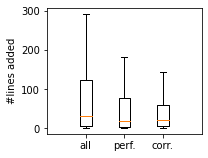

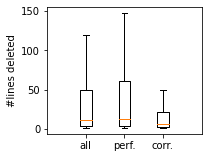

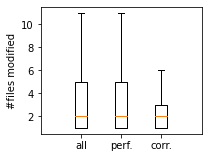

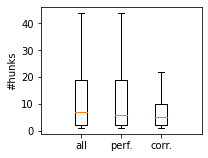

In [17]:
print_boxes_size(df, save=True)

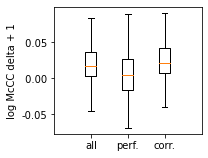

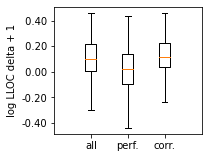

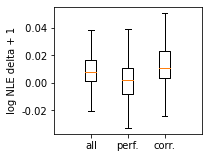

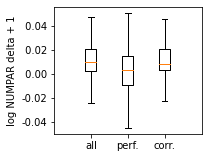

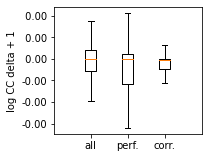

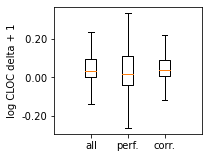

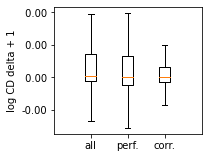

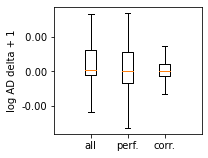

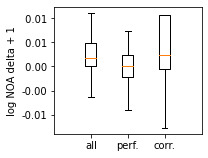

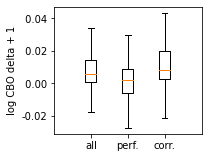

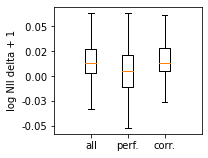

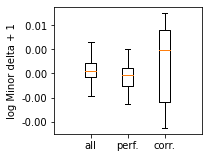

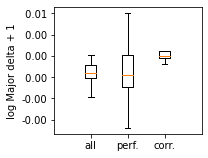

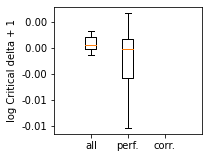

In [21]:
print_boxes_metrics(df, density=True)

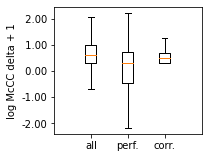

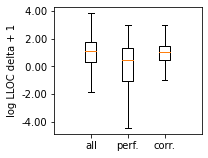

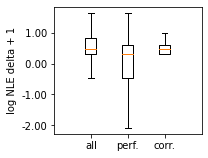

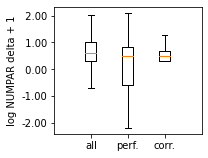

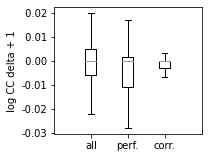

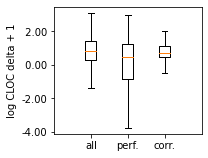

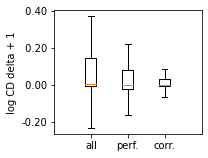

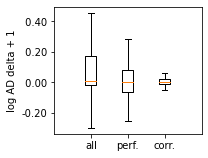

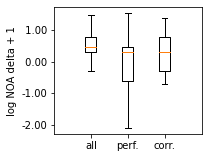

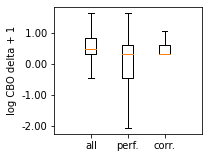

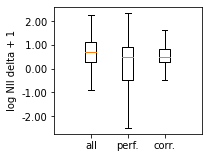

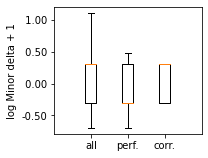

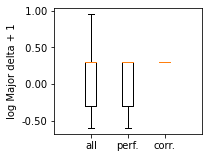

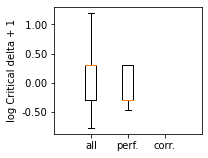

In [11]:
print_boxes_metrics(df, density=False)